In [215]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import collections
from google.colab import files
import sklearn # Only using to shuffle data

# Load data
!wget https://github.com/daniel-e/mnist_octave/raw/master/mnist.mat
data = sio.loadmat('mnist.mat')

--2022-11-20 04:35:58--  https://github.com/daniel-e/mnist_octave/raw/master/mnist.mat
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/daniel-e/mnist_octave/master/mnist.mat [following]
--2022-11-20 04:35:59--  https://raw.githubusercontent.com/daniel-e/mnist_octave/master/mnist.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14278089 (14M) [application/octet-stream]
Saving to: ‘mnist.mat.20’

mnist.mat.20        100%[===================>]  13.62M  --.-KB/s    in 0.04s   

2022-11-20 04:35:59 (335 MB/s) - ‘mnist.mat.20’ saved [14278089/14278089]



The shape of X_train is: (10000, 784)
The shape of Y_train is: (10000,)
The shape of X_test is: (1000, 784)
The shape of Y_test is: (1000,)

The label at index 0 is 9 and the image shows 


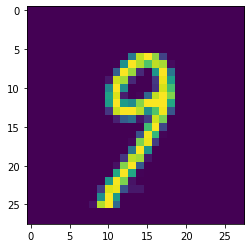

In [216]:
# Avoiding 0 values which could prevent weight updates
fac = 0.99 / 255
X_train = data['trainX'][:10000] * fac + 0.01
Y_train = data['trainY'][0][:10000]

X_test = data['testX'][:1000] * fac + 0.01
Y_test = data['testY'][0][:1000]

# Shuffle data in unison
X_train, Y_train = sklearn.utils.shuffle(X_train, Y_train)
X_test, Y_test = sklearn.utils.shuffle(X_test, Y_test)

print("The shape of X_train is: " + str(X_train.shape))
print("The shape of Y_train is: " + str(Y_train.shape))
print("The shape of X_test is: " + str(X_test.shape))
print("The shape of Y_test is: " + str(Y_test.shape))

# Used to see the real data directly from data set
def drawImg(sample):
    fig, ax = plt.subplots(1)
    ax.imshow(np.reshape(sample, (28, 28)))

drawImg(X_train[0])
print("\nThe label at index 0 is " + str(Y_train[0]) + " and the image shows ")

In [217]:
# PCA Implementation
def fit(X, n_comp):
  # Standardization
  mean = np.mean(X, axis=0)
  X = X - mean
       
  # Co-varience Matrix
  cov_mat = np.cov(X.T)
     
  # Find Eigen values and Eigen Vectors
  eig_vals, eig_vecs  = np.linalg.eig(cov_mat)
  eigpairs = [(eig_vals[i], eig_vecs[:,i]) for i in range(len(eig_vals))]
  eigpairs.sort(key=lambda x : x[0], reverse=True)
     
  # Create subspace
  subspace = np.array([eigpairs[i][1] for i in range(n_comp)])

  return subspace

def transform(X, subspace, mean):
  # Project data
  X = X - mean
  return np.dot(X, subspace.T)

In [218]:
M = 30
subspace = fit(X_train, M)
X_train_reduced  = transform(X_train, subspace, M)
X_test_reduced  = transform(X_test, subspace, M)
print("The shape of X_train_reduced  is: " + str(X_train_reduced.shape))
print("The shape of X_test_reduced  is: " + str(X_test_reduced.shape))

The shape of X_train_reduced  is: (10000, 30)
The shape of X_test_reduced  is: (1000, 30)


In [219]:
# Calculating Euclidean Distance
def distance(x,y):
    return np.sqrt(np.sum(np.square(x-y)))

# Applying K-nearest Neighbours
def knn(X_train, Y_train, X_test, k):
    # List of distances between test image and training images
    vals = []
    len_train = X_train.shape[0]
    
    for i in range(len_train):
      d = distance(X_test, X_train[i])
      vals.append((d, Y_train[i]))
        
    vals = sorted(vals)
    
    # Find the nearest first k points
    vals = vals[:k]
    vals = np.array(vals)
    
    # Find the maximum one from the index
    new_vals = np.unique(vals[:,1],return_counts = True)
    index = new_vals[1].argmax() 
    pred = new_vals[0][index]

    return pred

In [220]:
# Calcuating Accuracy
N = 1000
K = 5
def accuracy(X_train, Y_train, X_test, N, K):
    correct = 0
    incorrect = 0

    # Loop through test set and compare labels
    for i in range(N):
        pred = int(knn(X_train, Y_train, X_test[i], K)) 

        #print("Expected: " + str(Y_test[i]))
        #print("Actual: " + str(pred))

        if pred == Y_test[i]:
            correct += 1
        else:
            incorrect += 1

    accuracy = (correct/float(N))*100

    print("\nCorrect: " + str(correct))
    print("Incorrect: " + str(incorrect))  
    print("Accuracy: " + str(accuracy) + "%")

    return accuracy

accuracy(X_train_reduced, Y_train, X_test_reduced, N, K)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.



Correct: 937
Incorrect: 63
Accuracy: 93.7%


93.7

In [221]:
# Accuracy with respect to principal components 
score = []
for m in range(1, 31):
  subspace = fit(X_train, m)
  X_train_reduced  = transform(X_train, subspace, m)
  X_test_reduced  = transform(X_test, subspace, m)
  print('M =', m)
  acc = float(accuracy(X_train_reduced, Y_train, X_test_reduced, N, 5))
  score.append(acc)
  print("\n---------------\n")

M = 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: ignored

In [ ]:
# Graph
plt.plot(range(1, 31), score, marker='x')
plt.title('NN in PCA Space')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy (in % correctly classified')
plt.savefig('nn_pca.png', dpi=300)
plt.show()